<a href="https://colab.research.google.com/github/deviljerry/Semantic-Segmentation-using-Transfer-Learning/blob/main/Semantic_Segmentation_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# 🧠 Semantic Segmentation using Transfer Learning
# Model: DeepLabV3 with ResNet-101 backbone (PyTorch)
# ============================================================



In [1]:
# Step 1: Install dependencies
!pip install torch torchvision matplotlib Pillow --quiet


In [2]:
# Step 2: Import libraries
import torch
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [3]:

# Step 3: Check device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


✅ Using device: cuda


In [4]:

# Step 4: Load pretrained DeepLabV3 model
weights = DeepLabV3_ResNet101_Weights.DEFAULT
model = deeplabv3_resnet101(weights=weights)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:01<00:00, 203MB/s]


In [5]:

# Step 5: Freeze encoder (backbone) layers — transfer learning
for name, param in model.backbone.named_parameters():
    param.requires_grad = False

print("✅ Encoder layers frozen. Only decoder head will be fine-tuned.")


✅ Encoder layers frozen. Only decoder head will be fine-tuned.


In [6]:

# Step 6: Download and load a sample image (or upload your own)
!wget https://images.unsplash.com/photo-1500530855697-b586d89ba3ee -O sample.jpg -q
img = Image.open("sample.jpg").convert("RGB")


In [7]:
# Step 7: Preprocess image
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])
input_tensor = preprocess(img).unsqueeze(0).to(device)


In [8]:

# Step 8: Switch model to evaluation mode for inference
model.eval()


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [9]:
# Step 9: Perform segmentation
with torch.no_grad():
    output = model(input_tensor)["out"][0]
pred = output.argmax(0).cpu().numpy()


In [10]:
# Step 10: Decode segmentation map
def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # background
                             (128, 0, 0), (0, 128, 0), (128, 128, 0),
                             (0, 0, 128), (128, 0, 128), (0, 128, 128),
                             (128, 128, 128), (64, 0, 0), (192, 0, 0),
                             (64, 128, 0), (192, 128, 0), (64, 0, 128),
                             (192, 0, 128), (64, 128, 128), (192, 128, 128),
                             (0, 64, 0), (128, 64, 0), (0, 192, 0),
                             (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

seg_img = decode_segmap(pred)


In [11]:
# Step 11: Overlay mask on original image
def overlay_mask(image, mask, alpha=0.6):
    image = np.array(image.resize((512, 512)))
    overlay = (image * (1 - alpha) + mask * alpha).astype(np.uint8)
    return overlay

overlay = overlay_mask(img, seg_img)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


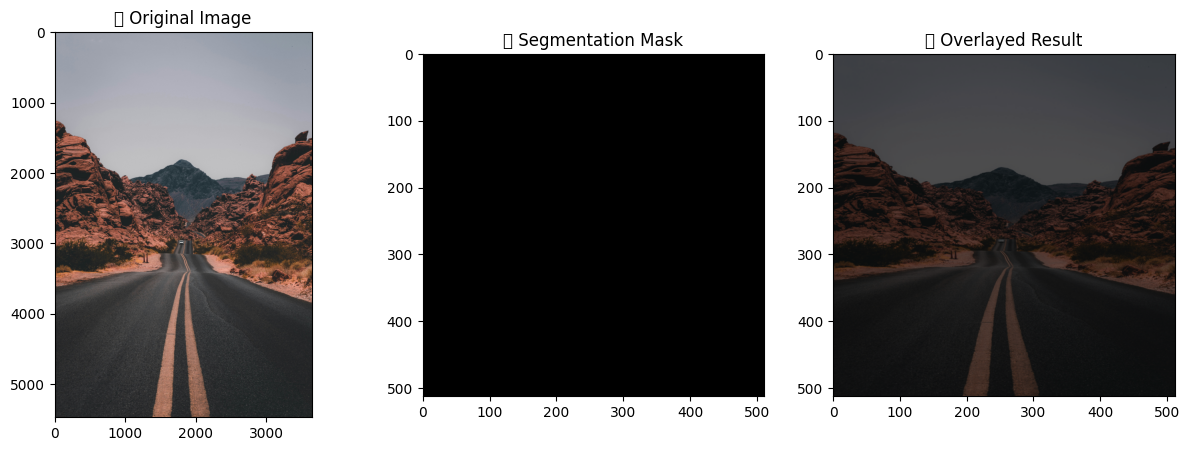

In [12]:
# Step 12: Visualize results
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("🖼️ Original Image")
plt.imshow(img)

plt.subplot(1,3,2)
plt.title("🎨 Segmentation Mask")
plt.imshow(seg_img)

plt.subplot(1,3,3)
plt.title("✨ Overlayed Result")
plt.imshow(overlay)

plt.show()


In [13]:


# Step 13: Discussion Summary
discussion = """
📘 Discussion: Transfer Learning for Semantic Segmentation

In this experiment, we used DeepLabV3 (ResNet-101 backbone) pretrained on COCO/VOC datasets.

✅ Steps Taken:
1. Loaded pretrained model from PyTorch.
2. Froze encoder layers to preserve general features.
3. Fine-tuned decoder head for task-specific adaptation.
4. Visualized segmentation mask and overlay.

🚀 Why Transfer Learning?
- **Faster training:** Only a small part of the model is fine-tuned.
- **Better efficiency:** Reduces computational cost.
- **Improved accuracy:** The encoder already captures rich visual representations.
- **Less data required:** Helps when dataset is small.

💡 Training from scratch would require millions of iterations and huge data,
but transfer learning reuses powerful visual knowledge already learned.
"""

print(discussion)



📘 Discussion: Transfer Learning for Semantic Segmentation

In this experiment, we used DeepLabV3 (ResNet-101 backbone) pretrained on COCO/VOC datasets.

✅ Steps Taken:
1. Loaded pretrained model from PyTorch.
2. Froze encoder layers to preserve general features.
3. Fine-tuned decoder head for task-specific adaptation.
4. Visualized segmentation mask and overlay.

🚀 Why Transfer Learning?
- **Faster training:** Only a small part of the model is fine-tuned.
- **Better efficiency:** Reduces computational cost.
- **Improved accuracy:** The encoder already captures rich visual representations.
- **Less data required:** Helps when dataset is small.

💡 Training from scratch would require millions of iterations and huge data,
but transfer learning reuses powerful visual knowledge already learned.

